<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/BERT_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Aug  5 07:16:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 4.9 MB/s 
     |████████████████████████████████| 895 kB 36.0 MB/s 
     |████████████████████████████████| 636 kB 45.6 MB/s 
     |████████████████████████████████| 3.3 MB 65.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# -*- coding: utf-8 -*-
"""8-1.news_group20.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1WD20ZqwWQhv615gwYSAn9WzMaFPiN3AN
"""
import numpy as np
import re
import pickle
from sklearn.datasets import fetch_20newsgroups
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# news data를 읽어온다.
newsData = fetch_20newsgroups(shuffle=True, random_state=1, remove=('footers', 'quotes'))

news = newsData['data']
topic = newsData['target']
n_topic = len(set(topic))

In [ ]:
# Subject만 추출한다.
subjects = []
y_topic = []
for text, top in zip(news, topic):
    for sent in text.split('\n'):
        idx = sent.find('Subject:')
        if idx >= 0:       # found
            subject = sent[(idx + 9):].replace('Re: ', '').lower()
            subject = re.sub("[^a-zA-Z]", " ", subject)
            if len(subject.split()) > 3:  # subject가 3단어 이상인 것만 허용한다.
                subjects.append(subject)
                y_topic.append(top)
            break


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir='bert_eng_ckpt', do_lower_case=False)

In [ ]:
enc = tokenizer.encode('i love you'.split())
dec = tokenizer.decode(enc)
print(enc)
print(dec)

[101, 1045, 2293, 2017, 102]
[CLS] i love you [SEP]


In [ ]:
word2idx = tokenizer.vocab
idx2word = {v:k for k, v in word2idx.items()}
[idx2word[x] for x in enc]

['[CLS]', 'i', 'love', 'you', '[SEP]']

In [ ]:
# word index로 변환한다.
subject_idx = [tokenizer.encode(s.split()) for s in subjects]
print(subject_idx[:10])

[[101, 19142, 100, 1998, 100, 102], [101, 100, 3980, 2000, 28363, 102], [101, 100, 2449, 2004, 5156, 102], [101, 7808, 4770, 3627, 13921, 102], [101, 2054, 2106, 23623, 5437, 2066, 102], [101, 17053, 4003, 2005, 100, 102], [101, 2053, 2455, 2005, 3521, 2053, 100, 102], [101, 2003, 100, 14639, 100, 102], [101, 4816, 100, 2001, 2109, 13154, 3160, 102], [101, 19804, 3274, 8389, 7692, 10328, 4882, 2112, 102]]


max =  29


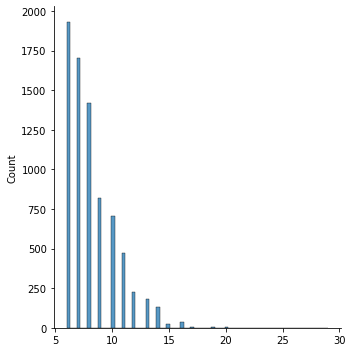

In [ ]:
MAX_LEN = 15
subject_len = [len(x) for x in subject_idx]
print('max = ', np.max(subject_len))
sns.displot(subject_len)

In [ ]:
# Bert Tokenizer
# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus
def bert_tokenizer(sent):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True    # Construct attn. masks.
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids']  # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

id, mask, typ = bert_tokenizer(subjects[0])
print(id)
print(mask)
print(typ)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[101, 19142, 23503, 2015, 1998, 12943, 28199, 2015, 102, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def build_data(doc):
    x_ids = []
    x_msk = []
    x_typ = []

    for sent in tqdm(doc):
        input_id, attention_mask, token_type_id = bert_tokenizer(sent)
        x_ids.append(input_id)
        x_msk.append(attention_mask)
        x_typ.append(token_type_id)

    x_ids = np.array(x_ids, dtype=int)
    x_msk = np.array(x_msk, dtype=int)
    x_typ = np.array(x_typ, dtype=int)

    return x_ids, x_msk, x_typ

In [ ]:
x_data = np.array(subjects)
y_data = np.array(y_topic).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6907,), (768,), (6907, 1), (768, 1))

In [ ]:
x_train_ids, x_train_msk, x_train_typ = build_data(x_train)
x_test_ids, x_test_msk, x_test_typ = build_data(x_test)

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

x_train_ids.shape, y_train.shape, x_test_ids.shape, y_test.shape

  0%|          | 0/6907 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 768/768 [00:00<00:00, 3273.72it/s]


((6907, 15), (6907, 1), (768, 15), (768, 1))

In [ ]:
# Load BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased', cache_dir='bert_eng_ckpt')
bert_model.summary() # bert_model을 확인한다. trainable params = 109,482,240

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# TFBertMainLayer는 fine-tuning을 하지 않는다. (시간이 오래 걸림)
bert_model.trainable = False
bert_model.summary() # bert_model을 다시 확인한다. trainable params = 0

Model: "tf_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 0
Non-trainable params: 109,482,240
_________________________________________________________________


In [ ]:
# BERT 입력
# ---------
x_input_ids = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)
x_input_msk = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)
x_input_typ = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)

# BERT 출력
# ---------
output_bert = bert_model([x_input_ids, x_input_msk, x_input_typ])

# Downstream task : 주제 분류 (multi class classification)
# -------------------------------------------------------
y_output = Dense(n_topic, activation = 'softmax')(output_bert[1])
model = Model([x_input_ids, x_input_msk, x_input_typ], y_output)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.01))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_4[0][0]                    
                                                                 input_5[0][0]              

In [ ]:
output_bert

TFBaseModelOutputWithPooling([('last_hidden_state',
                               <KerasTensor: shape=(None, 15, 768) dtype=float32 (created by layer 'tf_bert_model_1')>),
                              ('pooler_output',
                               <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model_1')>)])

In [ ]:
# 모델을 학습한다.
x_train = [x_train_ids, x_train_msk, x_train_typ]
x_test = [x_test_ids, x_test_msk, x_test_typ]
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=10, batch_size=1024)

Epoch 1/10
7/7 [==============================] - 20s 1s/step - loss: 4.0431 - val_loss: 3.6052
Epoch 2/10
7/7 [==============================] - 4s 588ms/step - loss: 3.3298 - val_loss: 3.2109
Epoch 3/10
7/7 [==============================] - 4s 588ms/step - loss: 2.9831 - val_loss: 2.8429
Epoch 4/10
7/7 [==============================] - 4s 587ms/step - loss: 2.7257 - val_loss: 2.6404
Epoch 5/10
7/7 [==============================] - 4s 587ms/step - loss: 2.6127 - val_loss: 2.5006
Epoch 6/10
7/7 [==============================] - 4s 589ms/step - loss: 2.4977 - val_loss: 2.3938
Epoch 7/10
7/7 [==============================] - 4s 587ms/step - loss: 2.4119 - val_loss: 2.3153
Epoch 8/10
7/7 [==============================] - 4s 588ms/step - loss: 2.3460 - val_loss: 2.2895
Epoch 9/10
7/7 [==============================] - 4s 587ms/step - loss: 2.3135 - val_loss: 2.2379
Epoch 10/10
7/7 [==============================] - 4s 587ms/step - loss: 2.2414 - val_loss: 2.1557


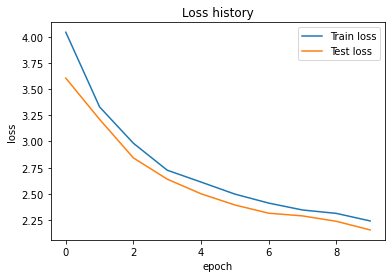

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1).reshape(-1, 1)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


Accuracy = 38.54 %
